<a href="https://colab.research.google.com/github/Silver0x10/VideoPrediction_MovingMNIST/blob/main/notebooks/VideoPredictionMovingMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
setup_already_done = False

In [3]:
import sys
import os

In [4]:
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [5]:
if not setup_already_done:
    if(IN_COLAB):
        !git clone https://github.com/Silver0x10/VideoPrediction_MovingMNIST.git
        %cd VideoPrediction_MovingMNIST
    else:
        %cd ..
    if(not os.path.exists("data/mnist_test_seq.npy")):
        if(not os.path.exists("data")):
            %mkdir data
        %cd data
        !wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
        %cd ..

    %pip install -qr requirements.txt  --quiet
    setup_already_done = True

/home/eddy/Projects/VideoPrediction_MovingMNIST
Note: you may need to restart the kernel to use updated packages.


In [6]:
!nvidia-smi

Sun Sep 10 11:55:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060        On  | 00000000:01:00.0  On |                  N/A |
| N/A   46C    P3              19W /  80W |    484MiB /  6144MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
!pwd
# %cd VideoPrediction_MovingMNIST/

/home/eddy/Projects/VideoPrediction_MovingMNIST


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader,random_split

import lightning.pytorch as pl
# from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

import numpy as np

# import pylab as plt
import matplotlib.pyplot as plt

import wandb

In [9]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

In [73]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# Dataset

In [12]:
from src.MovingMNIST import MovingMNIST
from src.parameters import shared_params

In [13]:
dataset = MovingMNIST(data_path="data/mnist_test_seq.npy")

In [14]:
train_set, validation_set, test_set = random_split(dataset,[8000, 1000, 1000],
                                                   generator=torch.Generator().manual_seed(42))

## Reference Sample

In [15]:
dataset.visualize_as_gif(42)
sequence_test = test_set[42]

In [16]:
print("Input:")
input_frames = sequence_test['frames']
dataset.visualize_given_frames_as_gif(input_frames)

Input:


In [17]:
print("Ground Truth:")
gt_frames = sequence_test['y']
dataset.visualize_given_frames_as_gif(gt_frames)

Ground Truth:


# 1) SimpleLSTM

In [18]:
from src.simpleLSTM import SimpleLSTM
from src.parameters import ParamsSimpleLSTM

params_simpleLSTM = ParamsSimpleLSTM()
model_simpleLSTM = SimpleLSTM(params_simpleLSTM)

In [19]:
params_simpleLSTM.training_epochs = 50
params_simpleLSTM.training_epochs

50

## Training + Testing

In [20]:
training_dataloader = DataLoader(train_set, batch_size = params_simpleLSTM.batch_size)
validation_dataloader = DataLoader(validation_set, batch_size = params_simpleLSTM.batch_size)
test_dataloader = DataLoader(test_set, batch_size = params_simpleLSTM.batch_size)

In [22]:
wandb_logger = WandbLogger(project='DeepLearning', name='SimpleLSTM_50epochs', log_model=True)

wandb: Currently logged in as: silver_man (worst_dream_team). Use `wandb login --relogin` to force relogin


In [23]:
wandb_logger.experiment.config['layers'] = str(model_simpleLSTM)

for p in vars(params_simpleLSTM).keys():
    wandb_logger.experiment.config[p] = vars(params_simpleLSTM)[p]

In [21]:
trainer_simpleLSTM = pl.Trainer(max_epochs=params_simpleLSTM.training_epochs,
                                accelerator=device.type,
                                logger=wandb_logger,
                                # deterministic=True,
                                # fast_dev_run=1,
                                # overfit_batches=1, # to test if the model can learn
                                detect_anomaly=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer_simpleLSTM.fit(model=model_simpleLSTM, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory ./DeepLearning/ercpa8lv/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | relu    | ReLU       | 0     
2 | encoder | Sequential | 12.6 M
3 | lstm    | LSTM       | 25.2 M
4 | decoder | Sequential | 12.6 M
---------------------------------------
50.4 M    Trainable params
0         Non-trainable params
50.4 M    Total params
201.433   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | MSELoss    | 0     
1 | relu    | ReLU       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [26]:
results_simpleLSTM = trainer_simpleLSTM.test(model_simpleLSTM, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2431.779541015625     │
└───────────────────────────┴───────────────────────────┘

## Visualization Example

In [ ]:
# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"
# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

In [30]:
print("Prediction:")
pred_simpleLSTM, _ = model_simpleLSTM(input_frames.unsqueeze(0))
pred_simpleLSTM = pred_simpleLSTM.detach().squeeze(0)
dataset.visualize_given_frames_as_gif(pred_simpleLSTM)

Prediction:


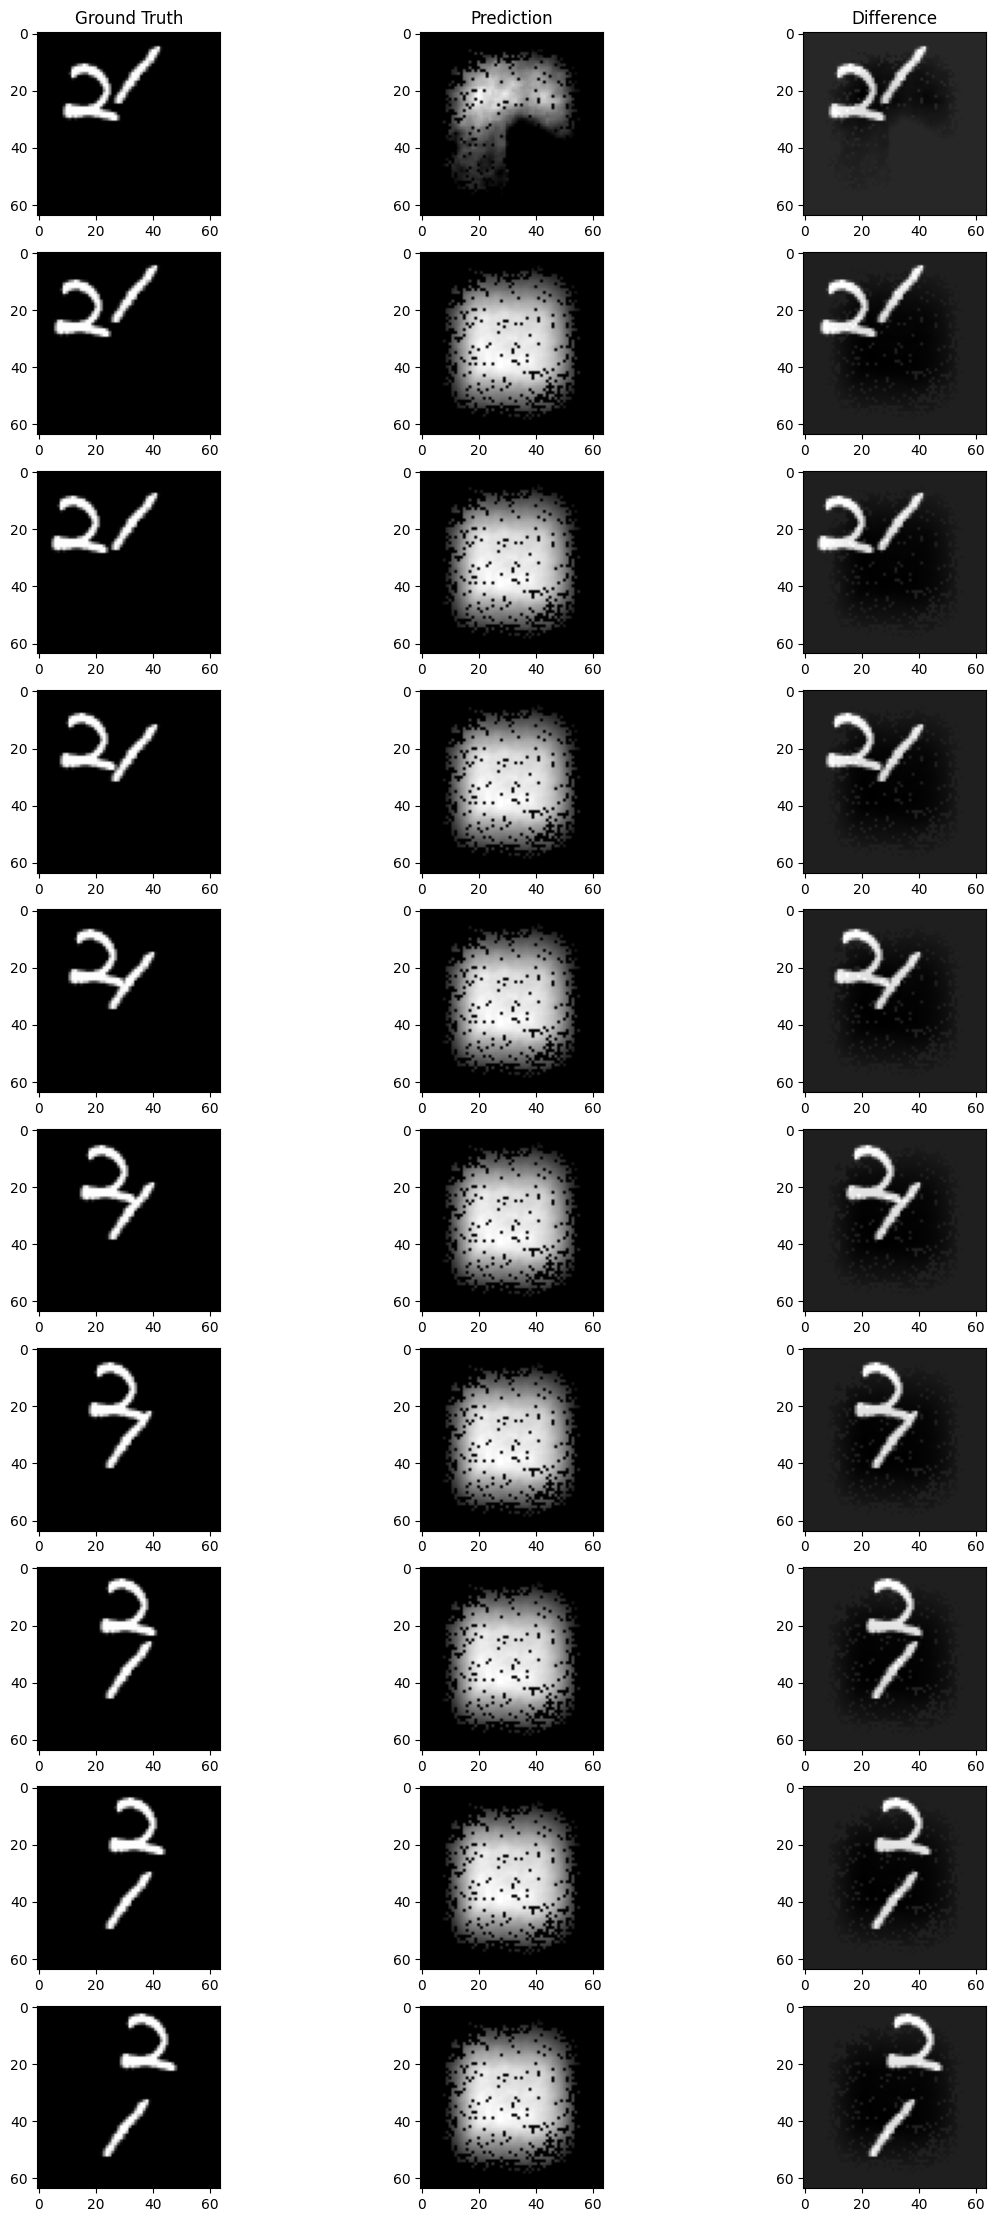

In [31]:
fig, ax = plt.subplots(10, 3, figsize=(14, 28))
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Prediction')
ax[0,2].set_title('Difference')

for i in range(gt_frames.shape[0]):
    gt_i = gt_frames[i, :, :]
    pred_i = pred_simpleLSTM[i, :, :]
    ax[i,0].imshow(gt_i, cmap='gray')
    ax[i,1].imshow(pred_i, cmap='gray')
    ax[i,2].imshow(gt_i - pred_i, cmap='gray')

fig.savefig('out/simpleLSTM_comparison.png')
wandb.log({"example": wandb.Image("out/simpleLSTM_comparison.png")})

fig.show()

## SimpleLSTM Finish

In [11]:
wandb.finish()

In [ ]:
# !zip -r ../logs lightning_logs/ # Remember to save weights (if needed)

# 2) ConvLSTM

In [153]:
from src.convLSTM import *
from src.parameters import ParamsConvLSTM

params_convLSTM = ParamsConvLSTM()
model_convLSTM = PlEncoderDecoder(k_s =3, Batch_size =1)#params_convLSTM.batch_size)

/home/eddy/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Training + Testing

In [155]:
training_dataloader = DataLoader(train_set, batch_size = params_convLSTM.batch_size)
validation_dataloader = DataLoader(validation_set, batch_size = params_convLSTM.batch_size)
test_dataloader = DataLoader(test_set, batch_size = params_convLSTM.batch_size)

In [156]:
wandb_logger = WandbLogger(project='DeepLearning', name='ConvLSTM', log_model=True)

In [157]:
wandb_logger.experiment.config['layers'] = str(model_convLSTM)

for p in vars(params_convLSTM).keys():
    wandb_logger.experiment.config[p] = vars(params_convLSTM)[p]

In [158]:
trainer_convLSTM= pl.Trainer(max_epochs=params_convLSTM.training_epochs,
                             accelerator=device.type,
                             logger=wandb_logger,
                            #  deterministic=True,
                            #  fast_dev_run=1,
                            # overfit_batches=1, # to test if the model can learn
                            detect_anomaly=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [159]:
trainer_convLSTM.fit(model=model_convLSTM, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [142]:
results_convLSTM = trainer_convLSTM.test(model_convLSTM, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/eddy/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2737.895263671875     │
└───────────────────────────┴───────────────────────────┘

## Reference Prediction:

In [143]:
# Load weights if needed

# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"
# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['state_dict'])
# model.eval()

In [144]:
print("Prediction:")
pred_convLSTM, _ = model_convLSTM(input_frames.unsqueeze(0))
pred_convLSTM = pred_convLSTM.detach().squeeze(0).cpu()
dataset.visualize_given_frames_as_gif(pred_convLSTM)

Prediction:


/tmp/ipykernel_38472/2578339650.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


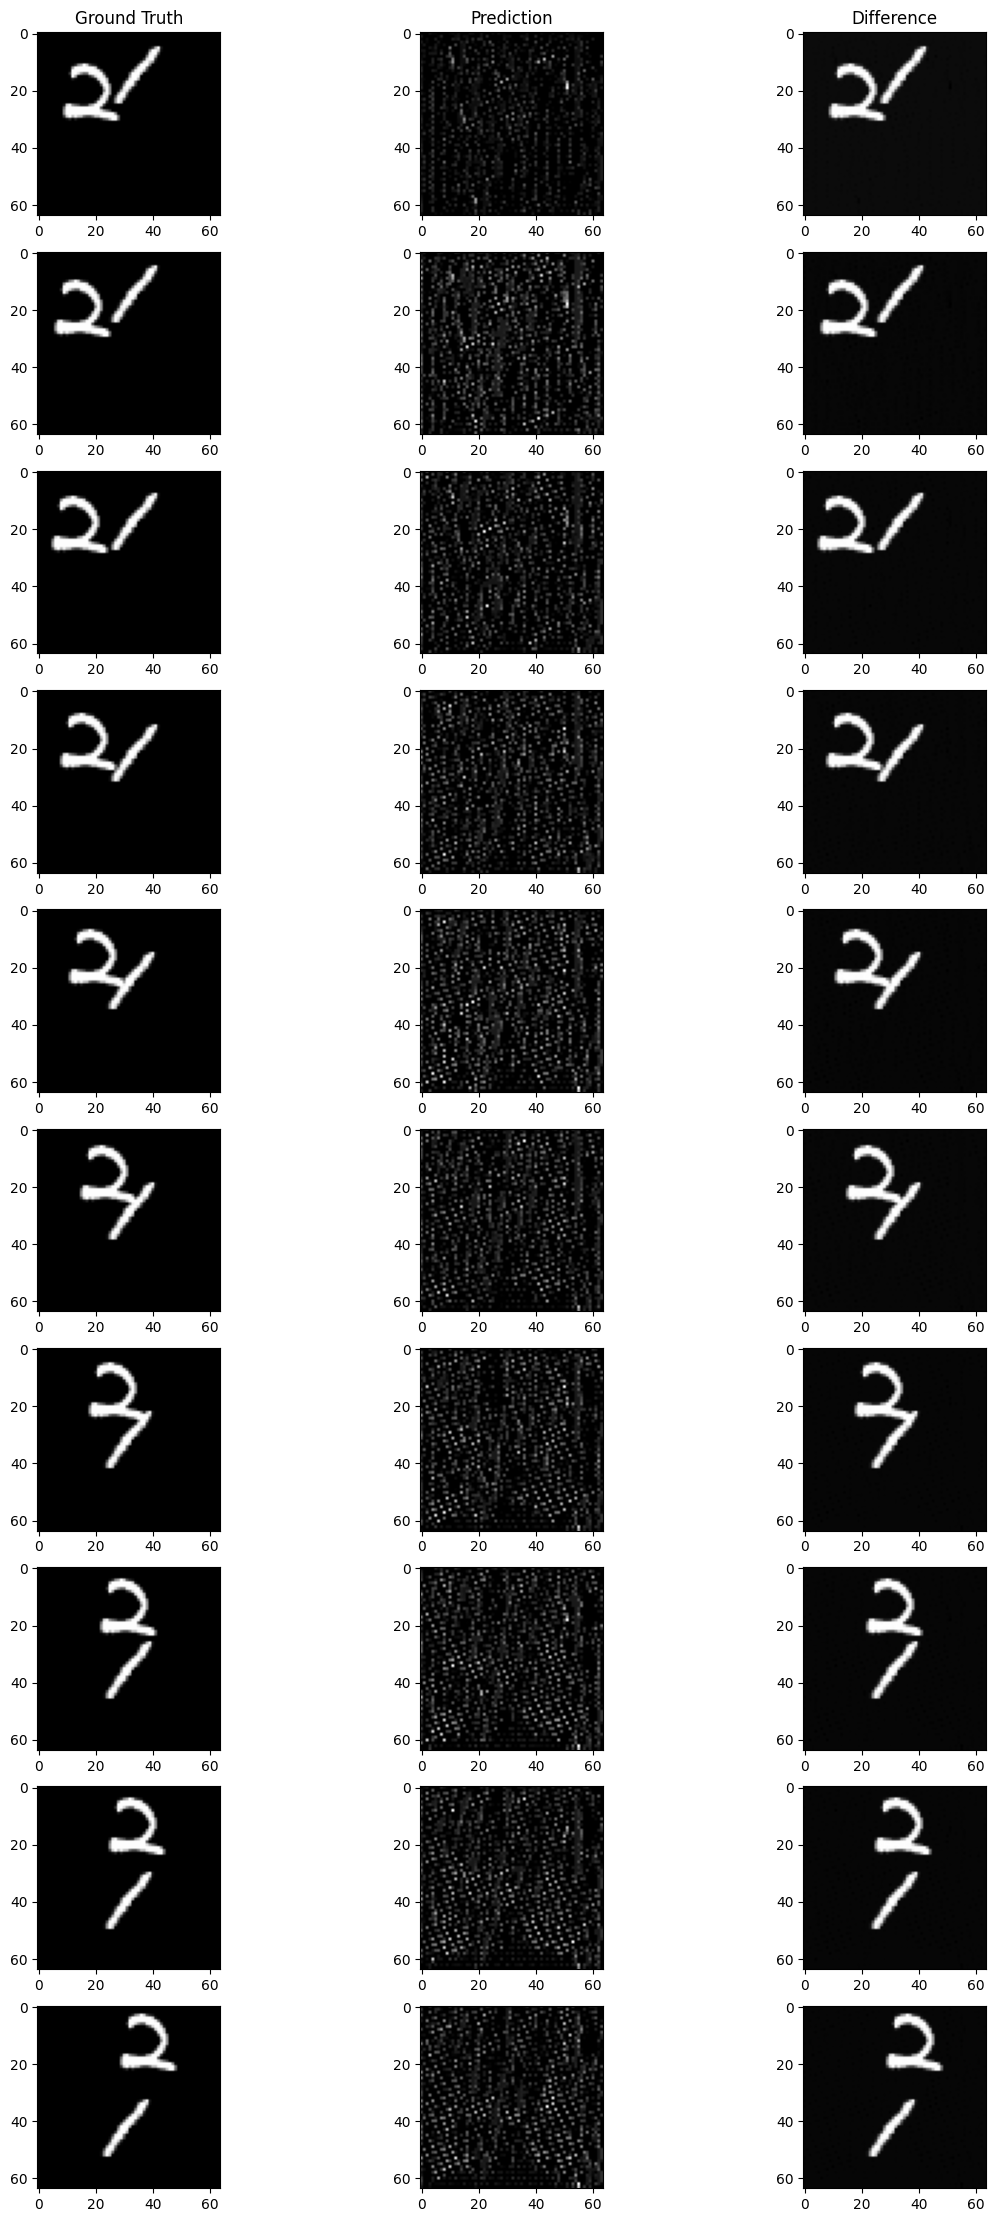

In [145]:
fig, ax = plt.subplots(10, 3, figsize=(14, 28))
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Prediction')
ax[0,2].set_title('Difference')

for i in range(gt_frames.shape[0]):
    gt_i = gt_frames[i, :, :]
    pred_i = pred_convLSTM[i, :, :].cpu()
    ax[i,0].imshow(gt_i, cmap='gray')
    ax[i,1].imshow(pred_i, cmap='gray')
    ax[i,2].imshow(gt_i - pred_i, cmap='gray')

fig.savefig('out/convLSTM_comparison.png')
wandb.log({"example": wandb.Image("out/convLSTM_comparison.png")})

fig.show()

## ConvLSTM Finish

In [152]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅████████
mse_epoch,█▁
mse_step,▆▄█▁▂▅▇▁▂▂▆▄█▁▂▅▇▁▂▂▆▄█▁▂▅▇▁
train_loss_epoch,█▁
train_loss_step,▆▄█▁▂▅▇▁▂▂▆▄█▁▂▅▇▁▂▂▆▄█▁▂▅▇▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
validation_loss,█▁
epoch,2
mse_epoch,2765.21167
mse_step,2525.58252
train_loss_epoch,2765.21167


In [ ]:
# !zip -r ../logs lightning_logs/ # Remember to save weights (if needed)

# 3) ConvTAU

In [37]:
from src.ConvTAU import *
from src.parameters import ParamsConvTAU

params_convTAU = ParamsConvTAU()
model_convTAU = ConvTAU(params_convTAU)

params_convTAU.training_epochs = 50

## Training + Testing

In [38]:
training_dataloader = DataLoader(train_set, batch_size = params_convTAU.batch_size)
validation_dataloader = DataLoader(validation_set, batch_size = params_convTAU.batch_size)
test_dataloader = DataLoader(test_set, batch_size = params_convTAU.batch_size)

In [40]:
wandb_logger = WandbLogger(project='DeepLearning', name='ConvTAU_50epochs', log_model=True)

In [41]:
wandb_logger.experiment.config['layers'] = str(model_convTAU)

for p in vars(params_convTAU).keys():
    wandb_logger.experiment.config[p] = vars(params_convTAU)[p]

In [42]:
trainer_convTAU = pl.Trainer(max_epochs=params_convTAU.training_epochs,
                             accelerator=device.type,
                             logger=wandb_logger,
                            #  deterministic=True,
                            #  fast_dev_run=1,
                            #  overfit_batches=1, # to test if the model can learn
                             detect_anomaly=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [43]:
trainer_convTAU.fit(model=model_convTAU, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | mse     | MSELoss | 0     
1 | encoder | Encoder | 40    
2 | tau     | TAU     | 690   
3 | decoder | Decoder | 40    
------------------------------------
770       Trainable params
0         Non-trainable params
770       Total params
0.003     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | mse     | MSELoss | 0     
1 | encoder | Encoder | 40    
2 | tau     | TAU     | 690   
3 | decoder | Decoder | 40    
------------------------------------
770       Trainable params
0         Non-trainable params
770       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [44]:
results_convTAU = trainer_convTAU.test(model_convTAU, dataloaders=test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_kl_loss        │    0.00332759041339159    │
│         test_loss         │      2564.498046875       │
│       test_mse_loss       │     2564.49462890625      │
└───────────────────────────┴───────────────────────────┘

## Visualization Example

In [45]:
# checkpoint_path = "lightning_logs/vo3td60s/checkpoints/epoch=9-step=80000.ckpt"
# # checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# checkpoint = torch.load(checkpoint_path)
# model_3.load_state_dict(checkpoint['state_dict'])
# model_3.eval()

In [46]:
print("Prediction:")
pred_convTAU = model_convTAU.single_prediction(input_frames).detach().squeeze(1)
dataset.visualize_given_frames_as_gif(pred_convTAU)

Prediction:


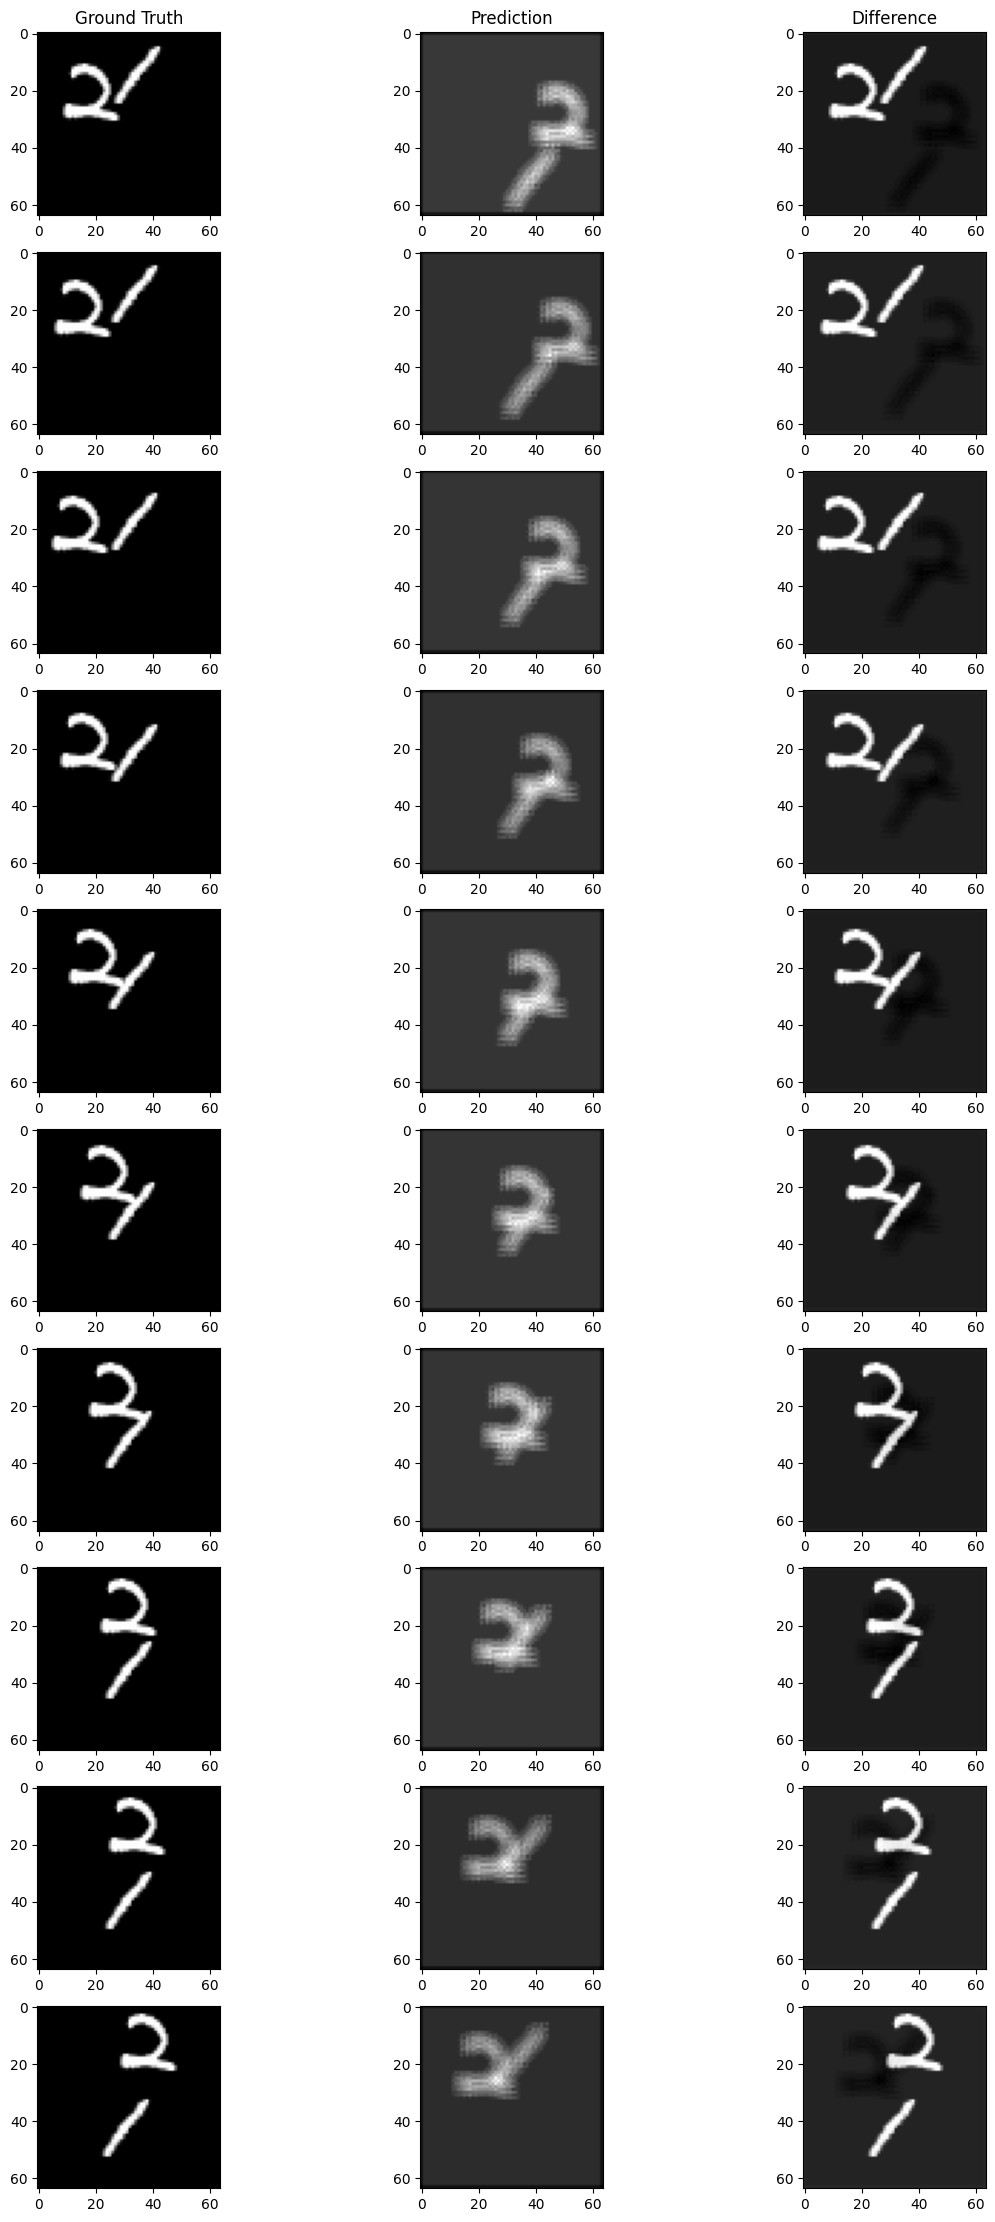

In [47]:
fig, ax = plt.subplots(10, 3, figsize=(14, 28))
ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Prediction')
ax[0,2].set_title('Difference')

for i in range(gt_frames.shape[0]):
    gt_i = gt_frames[i, :, :]
    pred_i = pred_convTAU[i, :, :]
    ax[i,0].imshow(gt_i, cmap='gray')
    ax[i,1].imshow(pred_i, cmap='gray')
    ax[i,2].imshow(gt_i - pred_i, cmap='gray')

fig.savefig('out/convTAU_comparison.png')
wandb.log({"example": wandb.Image("out/convTAU_comparison.png")})

fig.show()

## ConvTAU Finish

In [48]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_kl_loss,▁
test_loss,▁
test_mse_loss,▁
train_kl_loss_epoch,█▆▅▃▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_kl_loss_step,▅▃▆▂▄▁▅▆▅█▃▄█▃▅▄▅▅▄▅█▂▅█▂▅▄▅▅▄▅█▂▅█▂▅▄▅█
train_loss_epoch,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▁█▁▃█▁▃█▁█▁▃█▁▃█▁▃█▁█▁▃█▁▃█▁▃█▁█▁▃█▁▃█▁█
train_mse_loss_epoch,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse_loss_step,▁█▁▃█▁▃█▁█▁▃█▁▃█▁▃█▁█▁▃█▁▃█▁▃█▁█▁▃█▁▃█▁█
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [ ]:
# !zip -r ../logs lightning_logs/ # Remember to save weights (if needed)

# Extra / Trash

In [ ]:
# import gc
# print(torch.cuda.list_gpu_processes())
# gc.collect()
# torch.cuda.empty_cache()